In [1]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
from torch import nn, einsum
import torch.nn.functional as F

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor, Compose, Lambda, ToPILImage
from torchvision.utils import make_grid

/home/v_golov/dev/diffusion-models-learning/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [102]:
transform = Compose([
    ToTensor(),
    Lambda(lambda t: (t * 2) - 1),
    
])

training_data = MNIST(
    root="../data",
    train=True,
    download=True,
    transform=transform
)

test_data = MNIST(
    root="../data",
    train=False,
    download=True,
    transform=transform
)

In [103]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

In [104]:
batch = next(iter(train_dataloader))[0]

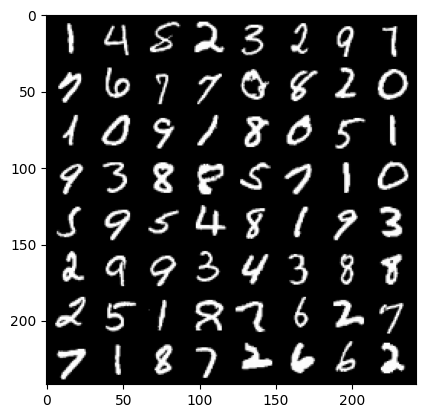

In [107]:
plt.imshow(make_grid(batch, nrow=8, pad_value=-1, normalize=False)[0], cmap='gray')
plt.show()

In [70]:
from torchdiffeq import odeint_adjoint as odeint

In [175]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

In [176]:
t = torch.arange(0, 301, 1)
beta = linear_beta_schedule(t.max())

In [177]:
def make_q_sample(x0, beta, noise=None):

    if noise is None:
        noise = torch.randn_like(x0)
    
    alpha = 1 - beta
    loc = torch.sqrt(alpha.cumprod(0))
    scale = torch.sqrt((1 - alpha.cumprod(0)))

    return torch.stack([loc[i] * x0 + scale[i] * noise for i, _ in enumerate(beta)])


In [178]:
noised = make_q_sample(batch, beta)

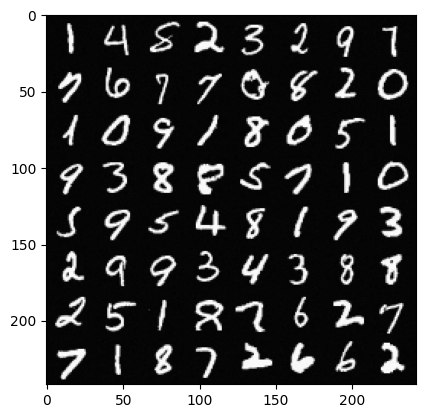

In [179]:
plt.imshow(make_grid(noised[0], nrow=8, pad_value=-1, normalize=False)[0], cmap='gray')
plt.show()

In [180]:
import numpy as np

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

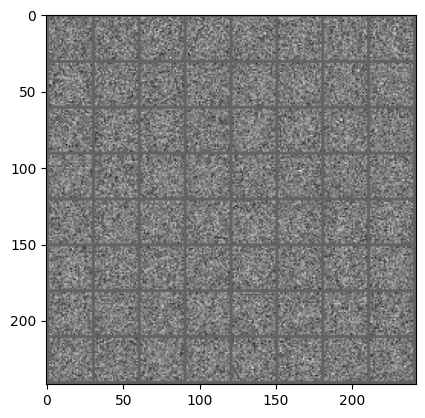

In [181]:
plt.imshow(make_grid(noised[-1], nrow=8, pad_value=-1, normalize=False)[0], cmap='gray')
plt.show()

In [210]:
class ODEF(nn.Module):

    def __init__(self) -> None:
        super().__init__()

        self.t_transform = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.ReLU()
        )
    
    def forward(self, t, x):

        t = torch.ones_like(x) * t
        t = self.t_transform(t)

        return x + t

In [241]:
t = 300
beta = linear_beta_schedule(t)
func = ODEF()
loss = nn.MSELoss()
optim = torch.optim.Adam(lr=1e-3, params=func.parameters())

for _ in range(1):

    for batch, mark in train_dataloader:

        optim.zero_grad()

        noised_batch = make_q_sample(batch, beta)
        pred = odeint(func, batch, beta, method='euler', adjoint_method='euler')

        l = loss(pred, noised_batch)
        l.backward()

        optim.step()

KeyboardInterrupt: 

In [259]:
img = odeint(func, torch.randn_like(batch), beta, method='euler', adjoint_method='euler')

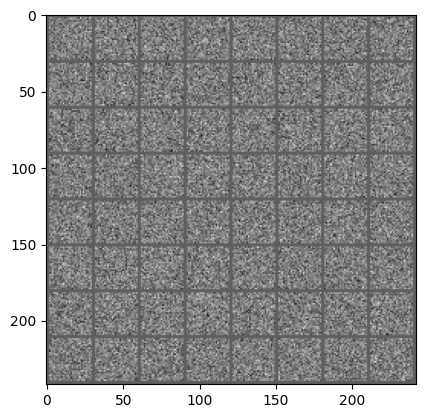

In [262]:
plt.imshow(make_grid(img[0], nrow=8, pad_value=-1, normalize=False)[0], cmap='gray')
plt.show()